In [1]:
import pandas as pd
import numpy as np
import itertools
import math
import sys
sys.path.insert(0, '../..')

import matplotlib.pyplot as plt

from g4l.data import Sample
import g4l.display
from g4l.tree import ContextTree
import g4l.tree.generation

#cache_dir = '../example1/cache'

In [2]:
# Create a sample object instance
X = Sample('../example1/publico.txt', [0, 1, 2, 3, 4])
t = ContextTree(X, max_depth=4, tree_initialization_method=g4l.tree.generation.incremental_strategy)

In [3]:
df = t.df.copy()
# initialize
df['final'] = 1
df['children_contrib'] = df.transition_sum_log_probs
df.loc[df.lps==0, 'children_contrib'] = -math.inf

In [4]:
# mark all nodes in the last level as leaves
df['type'] = 'N' # simple node

max_node_length = df.l.max() # 4
df.loc[df.l==max_node_length, 'type'] = 'L' # (mark as leaf)

In [5]:
df_results = pd.DataFrame(columns=['iter_num', 'num_nodes', 'log_likelihood_sum', 'node_idx'])
df_results.node_idx = df_results.node_idx.astype(object)

In [6]:
# iteration block

iteration_num = 0
while df.final.sum()>0:
    # fetch all nodes connected to leaf nodes and mark them as parent of leaves (LP)
    parent_node_idx = df.loc[(df.final==1) & (df.type=='L')].parent_idx.unique()
    df.loc[df.node_idx.isin(parent_node_idx), 'type'] = 'LP' # leaf parent

    # for all LP nodes, mark as candidate those ones that connects only with leaf nodes
    lp_nodes = df.loc[(df.type=='LP') & (df.final==1)]
    for idx, lp_node in lp_nodes.iterrows():
        child_nodes = df[df.parent_idx==lp_node.node_idx]

        num_child_nodes = len(child_nodes)
        active_child_nodes = (child_nodes.final==1).astype(int).sum()
        leaf_nodes = (child_nodes.type=='L').astype(int).sum()
        # when all child nodes are leaves and active
        if num_child_nodes == active_child_nodes == leaf_nodes:
            df.loc[df.node_idx==lp_node.node_idx, 'type'] = 'LPC' # mark these nodes as candidates (LPC)

    lpc = df[df.type=='LPC']
    if len(lpc)==0:
        break
    
    # for all the candidate nodes (LPC), calculate the less contributive
    less_contributive_lp_idx = np.array(lpc.sort_values(['children_contrib']).node_idx)[0]    
    
    # Eliminate leaves
    df.loc[df.parent_idx==less_contributive_lp_idx, 'final'] = 0

    # The less contributive LPC becomes a leaf
    df.loc[df.node_idx==less_contributive_lp_idx, 'type'] = 'L'
    iteration_num += 1

    active_nodes = df[df.final==1]
    # ['iter_num', 'num_nodes', 'log_likelihood_sum', 'node_idx']
    df_results.loc[len(df_results)] = [iteration_num, len(active_nodes), active_nodes[active_nodes.type=='L'].lps.sum(), np.array(active_nodes.node_idx)]

In [7]:
x = df_results.sort_values(['log_likelihood_sum'], ascending=False).node_idx[:1]
nodes_idx = x.to_numpy()[0]
new_df = t.df.copy()
new_df = new_df[new_df.node_idx.isin(nodes_idx)]
new_df.final = 1
new_t = ContextTree(X, max_depth=4, source_data_frame=new_df)

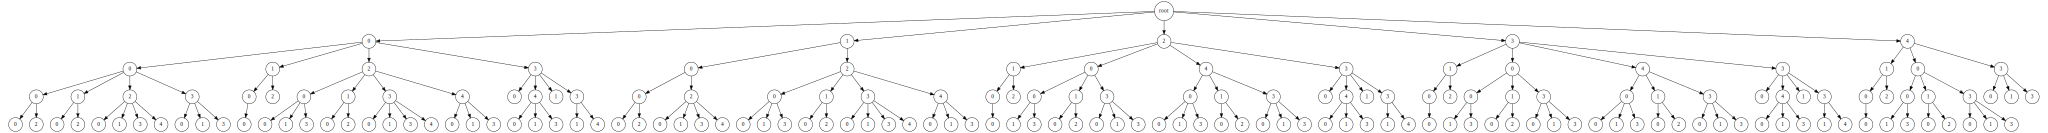

In [8]:
g4l.display.draw_tree(new_t.to_str(), size='40')
# the last iteration has length=1 

In [9]:
new_t.df

,node_idx,node,len_idx,node_freq,l,parent_idx,node_prob,lps,transition_sum_log_probs
0,0,3,0,8685,1,None,0.082458,-7262.864788,-9.686943
1,1,0,1,46674,1,None,0.443138,-66685.630033,-9.311966
2,2,2,2,23847,1,None,0.226411,-16294.669579,-1.406118
3,3,1,3,23847,1,None,0.226411,-20436.033116,-8.354481
4,4,4,4,2273,1,None,0.021581,-1468.123271,-1.485123
...,...,...,...,...,...,...,...,...,...
212,212,0343,138,11,4,71,0.423077,-11.398187,-3.504806
213,213,3433,139,2,4,72,0.105263,0.000000,0.000000
215,215,1343,141,6,4,73,0.857143,0.000000,0.000000
219,219,3432,145,5,4,72,0.263158,-3.365058,-1.427116


In [10]:
results = df_results.sort_values(['num_nodes'], ascending=True)

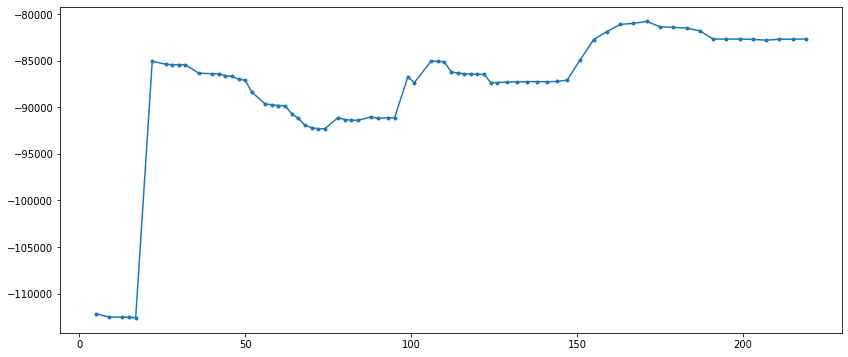

,iter_num,num_nodes,log_likelihood_sum,node_idx
73,74,5,-112147.320788,"[0, 1, 2, 3, 4]"
72,73,9,-112500.293076,"[0, 1, 2, 3, 4, 5, 14, 18, 20]"
71,72,13,-112516.070389,"[0, 1, 2, 3, 4, 5, 14, 18, 20, 34, 50, 56, 64]"
70,71,15,-112516.070389,"[0, 1, 2, 3, 4, 5, 14, 18, 20, 34, 50, 56, 64,..."
69,70,17,-112606.503054,"[0, 1, 2, 3, 4, 5, 14, 18, 20, 34, 50, 51, 56,..."
...,...,...,...,...
4,5,203,-82730.975694,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,4,207,-82807.024237,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,3,211,-82715.103262,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,2,215,-82702.169450,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [11]:
plt.figure(figsize=(14, 6))
plt.plot(results.num_nodes, results.log_likelihood_sum, marker='.')
plt.show()
results

In [12]:
t.log_likelihood()


-365594.09482525924

In [13]:
t.num_contexts()

223